## CATS vs DOGS FINE TUNING

### 1. Transfer learning and fine-tuning

Classifichiamo immagini di cani e gatti utilizzando il <b>Transfer learning</b> a partire da una rete pre-addestrata.

Un modello pre-addestrato è una <b>rete precedentemente addestrata</b> su un set di big data, in genere inerente un'attività di image recognition, e poi salvata in modo tale da essere utilizzata così com'è o utilizzare il Transfer learning per personalizzare il modello in base ad una determinata classificazione.

L'intuizione alla base del Transfer learning per la classificazione delle immagini è che un modello, se viene addestrato su un set di dati sufficientemente ampio e generale, può fungere efficacemente da modello generico per il "mondo visivo". È quindi possibile sfruttare tali rete senza dover costruire da zero un addestramento su un set di dati di grandi dimensioni.

<i>Come personalizzare un modello preaddestrato?</i>

- Nessun riaddestramento: non è necessario (ri)addestrare l'intero modello. La CNN di base contiene già feature che sono genericamente utili per classificare immagini. Tuttavia, la parte finale di classificazione del preaddestrato, è specifica per l'attività di classificazione e deve quindi essere adattata sulla base delle classi su cui è basata la propria predizione.

- Fine-tuning: si "freezano" i top layer di un modello base (ossia i layer basilari, solitamente tutti quelli prima del Flatten), per poi allenare congiuntamente la base del modello arricchita con i nuovi livelli aggiunti per la classificazione in questione. Questo permette di "perfezionare" (da qui, "fine-tuning") i pesi sulle feature di ordine superiore, adattando dunque la rete al problema specifico.


### 2. Download dataset ed esplorazione dati

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In questo tutorial utilizzeremo un set di dati contenente diverse migliaia di immagini di cani e gatti. Scarichiamo ed estraiamo un file zip contenente le immagini, quindi creiamo un tf.data.Dataset per l'addestramento e la validazione utilizzando <i>tf.keras.preprocessing.image_dataset_from_directory utility</i>.

In [2]:
# url for download
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# zip path extrapolation
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
# train-directory
train_dir = os.path.join(PATH, 'train')
# test-directory
validation_dir = os.path.join(PATH, 'validation')
# set parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
# create TRAIN-set
# batches of 32 images with dimension 160x160
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
# create VALIDATION-set
# batches of 32 images with dimension 160x160
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


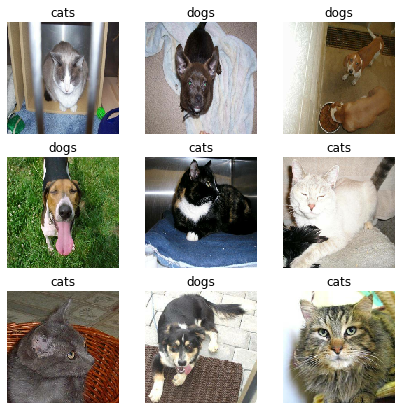

In [4]:
# data visualization
class_names = train_dataset.class_names
plt.figure(figsize=(7, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Poiché il set di dati originale non contiene un set di test, dobbiamo crearne uno. Per fare ciò, determiniamo il numero di batch disponibili nel set di validazione (usando <i>tf.data.experimental.cardinality</i>), quindi spostiamone il 20% sul test set.

<b>NB:</b> in questo tutorial VALIDAZIONE e TEST non si riferiscono allo stesso set! Il set di validazione è usato dopo l'apprendimento per validare il modello, mentre il test-set sarà utilizzato infine per effetturare delle predizioni su dati mai visti dalla rete.

In [5]:
# get the cardinality of validation_dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
# create test set for future predictions taking first 6 batches
test_dataset = validation_dataset.take(val_batches // 5)
# re-create validation set for future predictions, skipping the test one
validation_dataset = validation_dataset.skip(val_batches // 5)
# show information
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


Configuriamo il precaricamento con buffer in modo da caricare le immagini da disco senza che l'I/O diventi bloccante.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### 2.1. Aumento dei dati del dataset

<b>Aumentiamo i dati</b>. Quando non si dispone di un set di immagini di grandi dimensioni, è buona norma introdurre artificialmente una certa variabilità nei campioni, applicando trasformazioni casuali, ma realistiche, alle immagini di addestramento, come rotazioni o capovolgimenti orizzontali. Questo permette di esporre meno il modello al fenomeno di overfitting.

<b>NB:</b> questi strati aggiuntivi sono attivi solo durante l'addestramento, cioè quando si chiama <i>model.fit</i>. Essi sono inattivi quando il modello è utilizzato in modalità di inferenza (validazione).

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Ad esempio, applicando ripetutamente tali layer ad una stessa immagine, otteniamo i seguenti risultati:

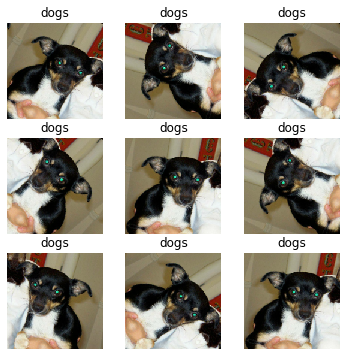

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(6, 6))
    first_image = images[0]
    first_label = labels[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[first_label])
        plt.axis('off')

La rete pre-allenata che useremo come modello base, tf.keras.applications.MobileNetV2, prevede valori dei pixel compresi in [-1, 1], mentre i valori attuali nelle nostre immagini sono tra [0, 255]. Ergo, ridimensioniamo.
Ciò si può fare o utilizzando il metodo di pre-elaborazione incluso con il modello o, in alternativa, con un layer di scalamento.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# alternatively
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### 3. Creazione del modello base a partire dalle Convnet pre-addestrate

Creiamo il modello base a partire dalla rete <b>MobileNet V2</b> sviluppata da <b>Google</b>. Essa è pre-addestrata su ImageNet, un grande set di dati composto da 1,4 milioni di immagini e 1000 classi. Questa base di conoscenza ci aiuterà a classificare cani e gatti dal nostro set specifico.


<br><div align="center"><img src="./imgs/Imagenet.jpg" width="500px"/></div><br>

Innanzitutto, bisogna scegliere su quale livello di MobileNet V2 effettuare feature-extraction, ossia dove "tagliare" la rete base per poter inserire i nostri layer personalizzati. L'ultimo livello di classificazione (in "alto", poiché la maggior parte dei diagrammi dei modelli di Machine Learning va dal basso verso l'alto) non è molto utile. Invece, <b>seguiamo la pratica comune di agganciarci all'ultimo strato prima dell'operazione di appiattimento (Flattern layer)</b>: questo strato è chiamato <b>"bottleneck layer"</b>.
Le feature a livello del "bottleneck layer", infatti, tendono a conservare una maggiore generalità rispetto al livello finale/superiore.

Innanzitutto, si crea un'istanza di MobileNet V2 precaricata, con pesi addestrati su ImageNet. Specificando <i>include_top=False</i> come argomento, diciamo di <i>non</i> includere gli strati di classificazione presenti nella parte superiore, il che è l'ideale nel nostro caso e, in generale, per personalizzare l'estrazione delle feature.

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

Questo "pezzo" di rete si ferma prima del Flatten, per cui è definibile come un feature-extractor: converte ogni immagine 160x160x3 in un blocco 5x5x1280 di features. Vediamo un esempio su un singolo batch di immagini:

In [11]:
image_batch, label_batch = next(iter(train_dataset))
# for example we pass from (32, 160, 160, 3) to (32, 5, 5, 1280) = 32 images with 5x5x1280 features
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### 4. Feature extraction

A questo punto, "freeziamo" la CNN di base creata in precedenza per usarla come feature extractor. Quindi, aggiungiamone un classificatore sul top, in modo da allenarlo per le nostre predizioni specifiche.


#### 4.1. Congelamento della CNN di base

Risulta fondamentale <i>freezare</i> la CNN di base prima del compile e del train del modello. "Freezare" (tramite. l'istruzione <i>layer.trainable = False</i>), infatti, <b>previene che i pesi di un dato layer vengano aggiornati</b> durante il training. Fallo per tutto il modello, quindi, ne congela i pesi per ogni livello presente nella rete.

In [12]:
base_model.trainable = False

In [13]:
# Let's take a look
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

<b>NB:</b> si possono notare nel summary alcuni BatchNormalization layer, i quali permettono di standardizzare gli input di un particolare layer (ossia le attivazioni dei livelli ad esso precendeti).
"Standardizzare" vuol dire applicare lo standard scaler (formula della <i>z-score</i> normalization) ed ottenere, sugli input di ogni layer della rete, approssimativamente media zero e varianza unitaria: matematicamente, il BN layer trasforma ogni input del batch corrente sottraendone individualmente la media del batch, per poi dividere per la deviazione standard. Ora, avere dei BatchNormalization layer comporta avere alcune precauzioni durante il fine-tuning: settando <i>layer.trainable = False</i>, il BN layer lavora in modalità di inferenza, quindi non aggiorna la sua media e la sua varianza statistica. Quindi, quando si scongela un modello che contiene BN per fare fine-tuning, bisogna mantenere tali layer in <i>inference mode</i>, passando <i>training = False</i> quando si chiama il modello base, altrimenti gli aggiornamenti applicati ai pesi non allenabili distruggerebbe ciò che ha già imparato il modello.

### 5. Aggiunta del classificatore sul top della base

Il classificatore al top della base serve per generare le nostre predizioni a partire dal blocco di feature restituito dalla rete base (5, 5, 1280). Sarà così costruito:

- Global Average Pooling 2D: layer di pooling che media su slice 5x5, quindi che converte le feature correnti in un array da 1280 elementi per ogni immagine.

- Dense layer: convertiamo queste 1280 feature in una predizione per ogni immagine. Non applichiamo nessuna activation function dal momento che la predizione sarà trattata come una logit (funzione di probabilità) o come <i>raw prediction value</i>. Numeri positivi predicono la classe 1, numero negativi predicono la classe 0.

Costruiamo quindi il modello finale concatenando assieme:
- il data augmentation layers
- il rescaling layers
- il modello base layers
- il feature extractorlayers

Usando le Keras Functional API. Come menzionato in precdenza, usiamo <i>training=False</i> nel nostro modello dal momento che sono presenti dei BatchNormalization layer all'interno della rete base.

In [14]:
# Global Average Pooling 2D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# for example we pass from (32, 5, 5, 1280) to (32, 1280)
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
# Dense layer
prediction_layer = tf.keras.layers.Dense(1)
# for example we pass from (32, 1280) to (32, 1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
# Build the model chaining together the data augmentation, rescaling, base_model and feature extractor layers
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### 5.1. Build del modello

Compiliamo e addestriamo il modello. Dal momento che ci sono due classi, usiamola binary cross-entropy come loss function, con <i>from_logits=True</i> dato l'output lineare.

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

I 2.5M di parametri della MobileNet sono congelati, ma ci sono 1.2K parametri addestabili nel Dense layer. Questi sono tf.Variable objects, divisi fra weights e biases.

In [19]:
# 2 = weights e biases
len(model.trainable_variables)

2

In [20]:
# show initial values
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 8s 236ms/step - loss: 1.0208 - accuracy: 0.3899
initial loss: 1.02
initial accuracy: 0.39


#### 5.2. Addestramento del modello

In [21]:
# training phase!
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 25s 365ms/step - loss: 0.8556 - accuracy: 0.4895 - val_loss: 0.6671 - val_accuracy: 0.6139
Epoch 2/10
63/63 [==============================] - 23s 361ms/step - loss: 0.6249 - accuracy: 0.6465 - val_loss: 0.4865 - val_accuracy: 0.7500
Epoch 3/10
63/63 [==============================] - 23s 359ms/step - loss: 0.4940 - accuracy: 0.7410 - val_loss: 0.3709 - val_accuracy: 0.8168
Epoch 4/10
63/63 [==============================] - 23s 366ms/step - loss: 0.4161 - accuracy: 0.7955 - val_loss: 0.2952 - val_accuracy: 0.8800
Epoch 5/10
63/63 [==============================] - 23s 360ms/step - loss: 0.3665 - accuracy: 0.8285 - val_loss: 0.2526 - val_accuracy: 0.9010
Epoch 6/10
63/63 [==============================] - 24s 379ms/step - loss: 0.3300 - accuracy: 0.8425 - val_loss: 0.2174 - val_accuracy: 0.9158
Epoch 7/10
63/63 [==============================] - 24s 385ms/step - loss: 0.3042 - accuracy: 0.8685 - val_loss: 0.1953 - val_accuracy: 0.9282

#### 5.3. Validazione del modello

Epoch 10/10
63/63 [==============================] - 28s 441ms/step

loss: 0.2014 - accuracy: <b>0.9135</b>

val_loss: 0.1242 - <b>val_accuracy: 0.9567</b>

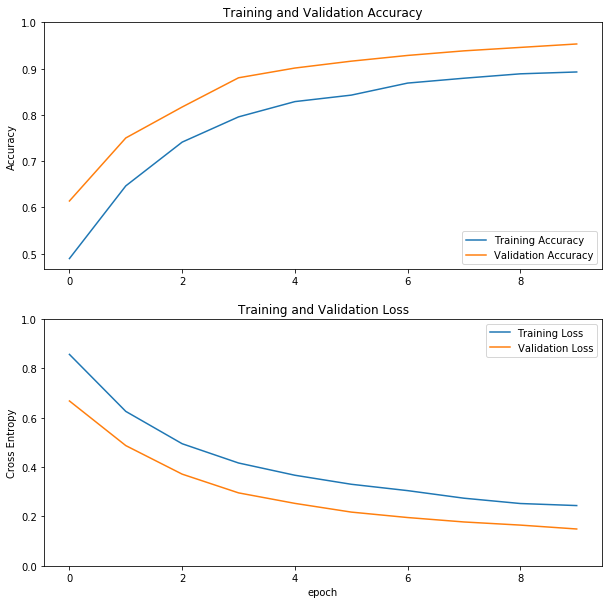

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2,1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<b>NB:</b> non succede spesso di avere un'accuracy di training minore rispetto all'accuracy di validazione! Il motivo principale di ciò è la presenza di livelli di BatchNormalization e Dropout, i quali agiscono e infulenzano le performance durante la fase di training, mentre <i>non</i> hanno effetto (sono layer "spenti") durante la validazione. 
In misura minore, è anche perché le metriche di addestramento riportano la media per un'epoca, mentre le metriche di validazione vengono valutate dopo la fine dell'epoca, dunque vedono un modello che è stato addestrato leggermente più a lungo rispetto al primo caso.

### 6. Fine tuning

Nell'esempio precedente di feature extraction, sono stati addestrati solo pochi layer sul top della rete di base MobileNet. I pesi della rete pre-trained <i>NON</i> sono stati dunque aggiornati durante il training.

Un modo per incrementare ancora di più le performance è fare <b>"fine-tune"</b>, cioè regolare i pesi dei top layers del modello pre-addestrato durante il training, assieme a quelli del classificatore aggiunto. Il processo di training forzerà la regolazione dei pesi da generiche feature maps a features associate al nostro specifico dataset.

<b>NB:</b> questa operazione è da farsi solo <b>dopo</b> aver trainato il classificatore top-level, con il modello pre-allenato di base settato a non-trainable (come fatto cioè nel primo esempio); infatti, se si aggiunge randomicamente un classificatore sul top del pre-allenato e si cerca di allenare tutti i layers assieme, gli aggiornamenti sul gradiente crescerbbero troppo in fretta (a causa dei pesi casuali del classificatore) portando il modello pre-addestrato a dimenticare ciò che ha imparato.

D'altra parte, il fine-tune andrebbe "per definizione" applicato su un piccolo numero di livelli al top della rete, piuttosto che sull'intera MobileNet! Nella maggior parte delle reti convoluzionali, infatti, tanto più un layer è "in alto" nel modello, tanto più è specializzato nel riconsocimento di specifiche feature; di contro, i primi layers imparano feature semplici ed astratte, appunto generalizzabili su quasi tutti i tipi di immagini.

Per cui l'obiettivo del fine-tuning è regolare i pesi degli ultimi layer in modo da adattarsi alle feature più "discriminanti" del proprio dataset di immagini (su cui poi si fa predizione), piuttosto che sovrascrivere un lavoro già ben fatto e collaudato di learning generico.

#### 6.1. Unfreeze dei top layers

Per applicare il fine-tuning bisogna "scongelare" il modello base e settare gli starti inferiori (facciamo dal 100-esimo in su, cioè da 0 a 99) come un-trainable. Quindi, si ricompila il modello e si fa training.

In [28]:
base_model.trainable = True

In [46]:
# take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# fine-tune from this layer onwards
fine_tune_at = 100

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
print("Number of layers TRAINABLE in the base model: ", len(base_model.layers)-fine_tune_at)

Number of layers in the base model:  154
Number of layers TRAINABLE in the base model:  54


#### 6.2. Compilazione e training della rete

Dal momento che si sta facendo training su un modello più largo e si vogliono riadattare pesi pretrained, è importante usare un learning rate inferiore rispetto all'esempio precedente, altrimenti il modello potrebbe overfittare velocemente.

In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [61]:
len(model.trainable_variables)

56

In [62]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# training phase!
# 10 epochs starting from the last (9) done before, hence Epoch 10/20 as first epoch
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 35s 503ms/step - loss: 0.1554 - accuracy: 0.9380 - val_loss: 0.0540 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 31s 491ms/step - loss: 0.1178 - accuracy: 0.9500 - val_loss: 0.0631 - val_accuracy: 0.9814
Epoch 12/20
63/63 [==============================] - 30s 483ms/step - loss: 0.0936 - accuracy: 0.9660 - val_loss: 0.0481 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 31s 484ms/step - loss: 0.0908 - accuracy: 0.9640 - val_loss: 0.0448 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 31s 498ms/step - loss: 0.0922 - accuracy: 0.9615 - val_loss: 0.0470 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 31s 489ms/step - loss: 0.0800 - accuracy: 0.9690 - val_loss: 0.0449 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 31s 491ms/step - loss: 0.0711 - accuracy: 0.9750 - val_loss: 0.0476 - val_accuracy:

Risultati all'ultima epoca:

Epoch 20/20
63/63 [==============================] - 31s 500ms/step - loss: 0.0594 - <b>accuracy: 0.9770</b> - val_loss: 0.0665 - <b>val_accuracy: 0.9740</b>.

Accodiamo i nuovi valori di accuracy e loss ai primi dieci registrati in precedenza, in modo da avere un quadro continuo dell'andamento. Quindi, plottiamo.

In [122]:
# RESTORE IF RUN MORE THAN ONE TIME
# acc = []
# val_acc = []
# loss = []
# val_loss = []
# history.history['accuracy'] = history.history['accuracy'][0:9]
# print(history.history['accuracy'])
# history.history['val_accuracy'] = history.history['val_accuracy'][0:9]
# print(history.history['val_accuracy'])
# history.history['loss'] = history.history['loss'][0:9]
# print(history.history['loss'])
# history.history['val_loss'] = history.history['val_loss'][0:9]
# print(history.history['val_loss'])
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
##############################################################################################
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
# print(len(acc))

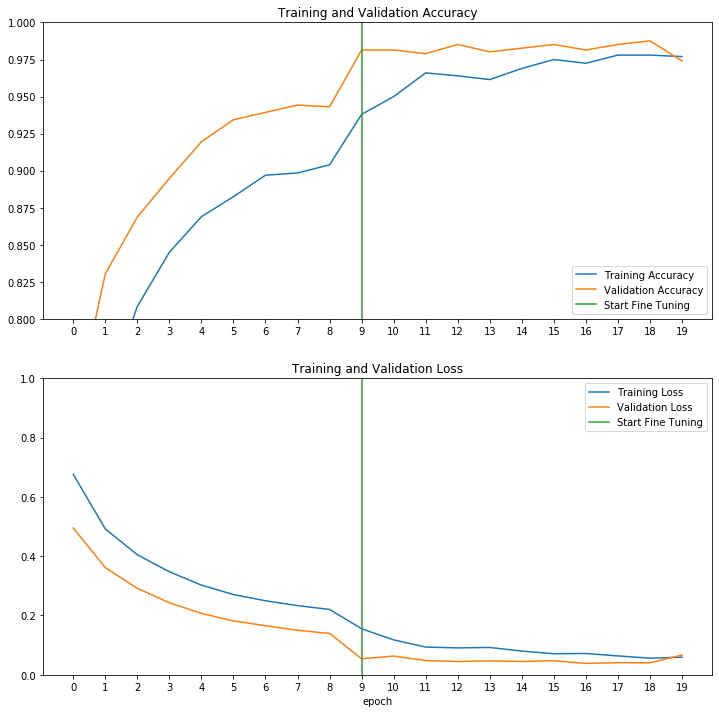

In [132]:
plt.figure(figsize=(12, 12))
##############################################################################################
plt.subplot(2,1, 1)
plt.xticks(range(0, 20))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
##############################################################################################
plt.subplot(2,1, 2)
plt.xticks(range(0, 20))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
##############################################################################################
plt.show()

### 7. Predizioni sul test set

In [ ]:
model.save("./fine-tuning-MobileNetV2")
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Le predizioni sono incoraggianti: oltre il 96% di accuratezza. Proviamo a predire qualche immagine.

Notare che il nostro modello ritorna valori secondo la funzione logits, la quale assume valori da -inf a +inf in un dominio [0;1]. Quindi usamo tali valori sulla funzione sigmoide per ottenere la predizione finale, arrotondando ad 1 se il valore restituito dalla sigmoide è superiore o uguale a 0.5, ponendo a 0 altrimenti.

<div align="center">
    <img src="./imgs/logit.png" width="350px"/>
    &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp
    <img src="./imgs/sigmoide.png" width="500px"/>
</div>

Predictions:
 [1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1]
Labels:
 [1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1]


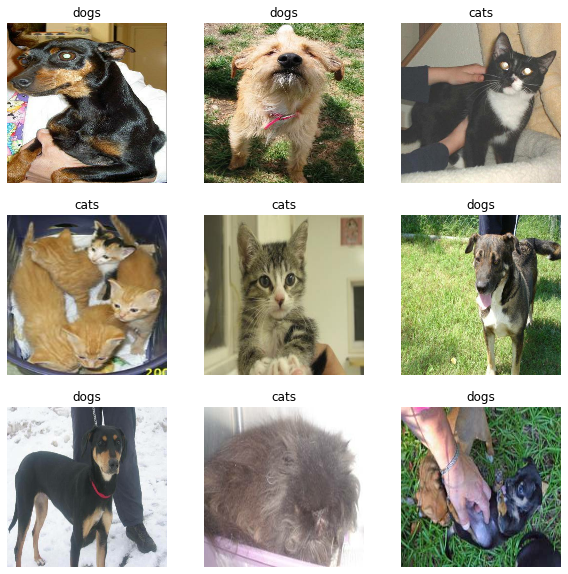

In [23]:
# first image features
# print(test_dataset.as_numpy_iterator().next()[0][0])
# first image labels
# print(class_names[test_dataset.as_numpy_iterator().next()[1][0]])

# retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

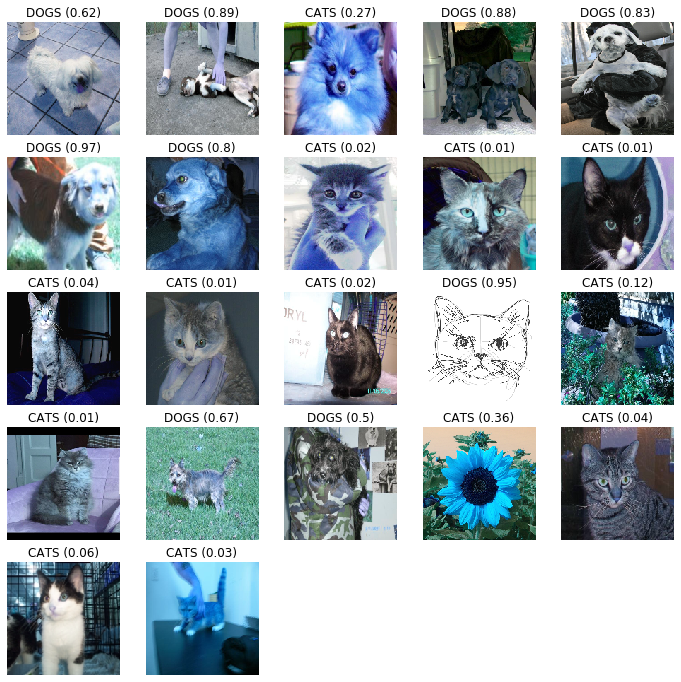

In [53]:
import cv2

def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, IMG_SIZE)
    return new_array, new_array.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

def predict_animal(filepath):
    image_to_plot, new_array = prepare(filepath)
    predictions = model.predict([new_array]).flatten()
    predictions = tf.nn.sigmoid(predictions)
    prediction = tf.where(predictions < 0.5, 0, 1)
    return image_to_plot, class_names[prediction.numpy()[0]], round(predictions.numpy()[0],2)


path = "./imgs/pets/"
col_index = 0
plt.figure(figsize=(12, 12))
for img in os.listdir(path):
    if not img.startswith("."):
        ax = plt.subplot(5, 5, col_index+1)
        image, label, pred = predict_animal(os.path.join(path, img))
        plt.imshow(image)
        plt.title(label.upper()+" ("+str(pred)+")")
        plt.axis(False)
        col_index+=1